In [2]:
import os
import cv2
from tqdm import tqdm

In [2]:
#!pip install opencv-python

In [3]:
#!pip install mtcnn

In [4]:
#!pip install tensorflow

In [5]:
#!pip install keras-visualizer

In [22]:
#!pip install scikit-learn

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 10.1 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/8.0 MB 11.2 MB/s eta 0:00:01
   ------- -------------------------------- 1.6/8.0 MB 2.9 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.0 MB 3.1 MB/s eta 0:00:02
   ----------------------------------- ---- 7.1/8.0 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 8.1 MB/s eta 0:00:00


In [7]:
#!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121

In [12]:
#!pip install torchvision==0.17.2

In [4]:
#!pip install numpy==1.26.4

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---- ----------------------------------- 1.8/15.5 MB 14.4 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/15.5 MB 26.9 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/15.5 MB 26.9 MB/s eta 0:00:01
   ------------------ --------------------- 7.1/15.5 MB 9.7 MB/s eta 0:00:01
   -------------------- ------------------- 8.1/15.5 MB 8.7 MB/s eta 0:00:01
   --------------------------- ------------ 10.7/15.5 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.2
    Uninstalling numpy-2.4.2:
      Successfully uninstalled numpy-2.4.2


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.9.4 requires ipython<9, but you have ipython 9.5.0 which is incompatible.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


# Extracting Frames

In [9]:
dataset_root = r"C:\Users\Student\Desktop\shreyank_research_project\FaceForensics++_C23"
original_vdo = os.path.join(dataset_root,"original")
deepfake_vdo = os.path.join(dataset_root,"Deepfakes")

output_root = r"C:\Users\Student\Desktop\shreyank_research_project\extrated_frames"

real_output = os.path.join(output_root,"real")
fake_output = os.path.join(output_root,"fake")

os.makedirs(real_output, exist_ok=True)
os.makedirs(real_output, exist_ok=True)

In [10]:
def extract_frames_from_video( video_path, save_dir, frame_rate=10):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_save_dir = os.path.join(save_dir, video_name)
    os.makedirs(video_save_dir, exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_rate == 0:
            frame_path = os.path.join(video_save_dir, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1
        frame_count += 1
    cap.release()

In [11]:
real_videos = [
    os.path.join(original_vdo, v)
    for v in os.listdir(original_vdo)
    if v.endswith((".mp4",".avi",".mov"))
]

print(f"Found {len(real_videos)} real videos")

for video_path in tqdm(real_videos, desc="Extracting real frames"):
    extract_frames_from_video( video_path = video_path, save_dir = real_output, frame_rate=10)
        

Found 1000 real videos


Extracting real frames:   4%|██▏                                                     | 39/1000 [00:35<14:25,  1.11it/s]


KeyboardInterrupt: 

In [ ]:
fake_videos = [
    os.path.join(deepfake_vdo, v)
    for v in os.listdir(deepfake_vdo)
    if v.endswith((".mp4",".avi",".mov"))
]

print(f"Found {len(fake_videos)} fake videos")

for video_path in tqdm(fake_videos, desc="Extracting fake frames"):
    extract_frames_from_video( video_path = video_path, save_dir = fake_output, frame_rate=10)
        

In [ ]:
def count_images(folder):
    total = 0
    for root, _, files in os.walk(folder):
        total += len([f for f in files if f.endswith(".jpg")])
    return total

print("real frames :", count_images(real_output))
print("fake frames :", count_images(fake_output))

# Face Detection, alignment and cropping

In [ ]:
import numpy as np
from mtcnn import MTCNN

In [ ]:
frames_root = r"C:\Users\Student\Desktop\shreyank_research_project\extrated_frames"
real_frames = os.path.join(frames_root, "real")
fake_frames = os.path.join(frames_root, "fake")

face_output_root = r"C:\Users\Student\Desktop\shreyank_research_project\aligned_faces"

real_face_out = os.path.join(face_output_root, "real")
fake_face_out = os.path.join(face_output_root, "fake")

os.makedirs(real_face_out, exist_ok=True)
os.makedirs(fake_face_out, exist_ok=True)

In [ ]:
detector = MTCNN()

In [ ]:
def align_and_crop_face(image, output_size=(224, 224)):
    if image is None:
        return None
        
    image_rgb = image 

    try:
        detections = detector.detect_faces(image_rgb)
    except Exception as e:
        return None
    
    if not detections:
        return None
    
    face = max(detections, key=lambda x: x['confidence'])
    
    keypoints = face['keypoints']
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    
    eyes_center = (
        (left_eye[0] + right_eye[0]) / 2.0,
        (left_eye[1] + right_eye[1]) / 2.0
    )
    
    rot_mat = cv2.getRotationMatrix2D(eyes_center, angle, scale=1.0)
    aligned_image = cv2.warpAffine(
        image_rgb,
        rot_mat,
        (image_rgb.shape[1], image_rgb.shape[0]),
        flags=cv2.INTER_CUBIC
    )
    
    x, y, w, h = face['box']
    
    img_h, img_w = aligned_image.shape[:2]
    x1 = max(0, x)
    y1 = max(0, y)
    x2 = min(img_w, x1 + w)
    y2 = min(img_h, y1 + h)
    
    cropped_face = aligned_image[y1:y2, x1:x2]
    
    if cropped_face.size == 0 or cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
        return None
    
    try:
        return cv2.resize(cropped_face, output_size)
    except cv2.error:
        return None

In [ ]:
def process_frames(input_root,output_root):
    for video_folder in tqdm(os.listdir(input_root)):
        video_path = os.path.join(input_root, video_folder)
       
        if not os.path.isdir(video_path):
            continue
       
        save_video_dir = os.path.join(output_root, video_folder)
        os.makedirs(save_video_dir, exist_ok=True)
       
        for img_name in os.listdir(video_path):
            if not img_name.endswith(".jpg"):
                continue
           
            img_path = os.path.join(video_path, img_name)
            image = cv2.imread(img_path)
           
            if image is None:
                continue
           
            face = align_and_crop_face(image)
           
            if face is not None:
                save_path = os.path.join(save_video_dir, img_name)
                cv2.imwrite(save_path, face)

In [ ]:
process_frames(
    input_root = real_frames,
    output_root = real_face_out)

print("processing real frames...")

In [ ]:
process_frames(
    input_root = fake_frames,
    output_root = fake_face_out)

In [ ]:
def count_images(folder):
    total = 0
    for root, _, files in os.walk(folder):
        total += len([f for f in files if f.endswith(".jpg")])
    return total

In [ ]:
print("Real :", count_images(real_face_out))
print("Fake :", count_images(fake_face_out))

# Eyes and nose cropping

In [ ]:
ALIGNED_ROOT = r"C:\Users\Student\Desktop\shreyank_research_project\aligned_faces"

REAL_FACES = os.path.join(ALIGNED_ROOT, "real")
FAKE_FACES = os.path.join(ALIGNED_ROOT, "fake")

REGION_ROOT = r"C:\Users\Student\Desktop\shreyank_research_project\region_crop"

EYES_REAL = os.path.join(REGION_ROOT, "eyes", "real")
EYES_FAKE = os.path.join(REGION_ROOT, "eyes", "fake")

NOSE_REAL = os.path.join(REGION_ROOT, "nose", "real")
NOSE_FAKE = os.path.join(REGION_ROOT, "nose", "fake")

for path in [EYES_REAL, EYES_FAKE, NOSE_REAL, NOSE_FAKE]:
    os.makedirs(path, exist_ok=True)

In [ ]:
#cropping eyes
def crop_eyes(face_img, output_size=(96, 64)):
    img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    
    try:
        detections = detector.detect_faces(img_rgb)
    except Exception as e:
        return None

    if not detections:
        return None
    
    keypoints = detections[0]['keypoints']
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    x_min = min(left_eye[0], right_eye[0]) - 20
    x_max = max(left_eye[0], right_eye[0]) + 20
    y_min = min(left_eye[1], right_eye[1]) - 20
    y_max = max(left_eye[1], right_eye[1]) + 20
    
    h, w, _ = face_img.shape
    x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
    x_max, y_max = min(w, int(x_max)), min(h, int(y_max))
    
    eye_crop = face_img[y_min:y_max, x_min:x_max]
    
    if eye_crop.size == 0:
        return None
    
    return cv2.resize(eye_crop, output_size)

In [ ]:
#cropping nose
def crop_nose(face_img, output_size=(64, 64)):
    img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    
    try:
        detections = detector.detect_faces(img_rgb)
    except Exception:
        return None
    
    if not detections:
        return None
    
    keypoints = detections[0]['keypoints']
    nose = keypoints['nose']
    
    x_min = nose[0] - 25
    x_max = nose[0] + 25
    y_min = nose[1] - 25
    y_max = nose[1] + 35
    
    h, w, _ = face_img.shape
    x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
    x_max, y_max = min(w, int(x_max)), min(h, int(y_max))
    
    nose_crop = face_img[y_min:y_max, x_min:x_max]
    
    if nose_crop.size == 0:
        return None
    
    return cv2.resize(nose_crop, output_size)

In [ ]:
#process dataset and apply these cropping functions on aligned faces
def process_region_crops(input_root, eye_out, nose_out):
    for video_folder in tqdm(os.listdir(input_root)):
        video_path = os.path.join(input_root, video_folder)
        
        if not os.path.isdir(video_path):
            continue
        
        eye_save_dir = os.path.join(eye_out, video_folder)
        nose_save_dir = os.path.join(nose_out, video_folder)
        
        os.makedirs(eye_save_dir, exist_ok=True)
        os.makedirs(nose_save_dir, exist_ok=True)
        
        for img_name in os.listdir(video_path):
            if not img_name.endswith(".jpg"):
                continue
            
            img_path = os.path.join(video_path, img_name)
            face_img = cv2.imread(img_path)
            
            if face_img is None:
                continue
            
            eye_crop = crop_eyes(face_img)
            nose_crop = crop_nose(face_img)
            
            if eye_crop is not None:
                cv2.imwrite(os.path.join(eye_save_dir, img_name), eye_crop)
            
            if nose_crop is not None:
                cv2.imwrite(os.path.join(nose_save_dir, img_name), nose_crop)

In [ ]:
print("Processing REAL face crops...")
process_region_crops(
    input_root=REAL_FACES,
    eye_out=EYES_REAL,
    nose_out=NOSE_REAL
)

In [ ]:
print("Processing FAKE face crops...")
process_region_crops(
    input_root=FAKE_FACES,
    eye_out=EYES_FAKE,
    nose_out=NOSE_FAKE
)

In [ ]:
def count_images(folder):
    total = 0
    for root, _, files in os.walk(folder):
        total += len([f for f in files if f.endswith(".jpg")])
    return total

print("Eye crops:")
print("REAL:", count_images(EYES_REAL))
print("FAKE:", count_images(EYES_FAKE))

print("\nNose crops:")
print("REAL:", count_images(NOSE_REAL))
print("FAKE:", count_images(NOSE_FAKE))

# Full-Face Model Training (U-Net + ViT)

In [3]:
import os
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms

In [4]:
DATASET_ROOT = r"C:\Users\Student\Desktop\shreyank_research_project\aligned_faces"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

In [5]:
#TensorFlow expects images directly inside class folders — so we build a custom tf.data pipeline.

def load_image_paths(root_dir):
    image_paths = []
    labels = []
    
    for label, class_name in enumerate(["real", "fake"]):
        class_path = os.path.join(root_dir, class_name)
        for video in os.listdir(class_path):
            video_path = os.path.join(class_path, video)
            if not os.path.isdir(video_path):
                continue
            for img in os.listdir(video_path):
                if img.endswith(".jpg"):
                    image_paths.append(os.path.join(video_path, img))
                    labels.append(label)
    
    return image_paths, labels

In [6]:
image_paths, labels = load_image_paths(DATASET_ROOT)

print("Total images:", len(image_paths))

Total images: 101281


In [7]:
print(type(labels))
print(len(labels))
print(labels[:20])

import numpy as np

labels_np = np.array(labels)

unique, counts = np.unique(labels_np, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

<class 'list'>
101281
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class distribution: {0: 50785, 1: 50496}


**tf.data pipeline**

In [8]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

In [9]:
#training and validation split, 80,20

dataset = FaceDataset(image_paths, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

**U-Net Encoder Architecture**

In [21]:
class UNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.pool1(self.block1(x))
        x = self.pool2(self.block2(x))
        x = self.block3(x)
        return x

In [22]:
#UNET classifier for testing

class UNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = UNetEncoder()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.encoder(x)          # [B, 256, 56, 56]
        x = self.pool(x)             # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)    # [B, 256]
        return self.classifier(x)

In [35]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = UNetClassifier().to(device)
# print("Phase 1 U-Net-only model created")

In [23]:
#load feature map of trained unet and freeze its encoder part.
state_dict = torch.load(
    r"C:\Users\Student\Desktop\shreyank_research_project\Model Weights\full_face_unet_test_phase_1.pth",
    map_location=device
)
encoder_state_dict = {
    k.replace("encoder.", ""): v
    for k, v in state_dict.items()
    if k.startswith("encoder.")
}
encoder = UNetEncoder().to(device)
encoder.load_state_dict(encoder_state_dict)
for param in encoder.parameters():
    param.requires_grad = False

In [24]:
class AttentionMask(nn.Module):
    def __init__(self, in_channels=256):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        mask = self.attn(x)
        return x * mask

**Vision Trandformer Architecture**

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=256, embed_dim=256, patch_size=4):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, dim=256, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

**Frozen U-Net Encoder + ViT Model**

In [27]:
class UNetViT_Phase2(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder   # frozen
        self.patch = PatchEmbedding()
        self.transformer = nn.Sequential(
            *[TransformerBlock() for _ in range(6)]
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        tokens = self.patch(features)
        tokens = self.transformer(tokens)
        x = tokens.mean(dim=1)
        return self.classifier(x)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNetViT_Phase2(encoder).to(device)
print("Phase 2 model created")

Phase 2 model created


**Frozen U-Net Encoder + Attention + ViT Model**

In [29]:
class UNetViT_Phase3(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.attention = AttentionMask()

        self.patch = PatchEmbedding()
        self.transformer = nn.Sequential(
            *[TransformerBlock() for _ in range(6)]
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        features = self.encoder(x)              # [B, 256, 56, 56]
        features = self.attention(features)     # attention-refined

        tokens = self.patch(features)
        tokens = self.transformer(tokens)

        x = tokens.mean(dim=1)
        return self.classifier(x)                # raw logits

In [30]:
for p in encoder.parameters():
    p.requires_grad = False             #freeze everything

for p in encoder.block3.parameters():
    p.requires_grad = True             #unfreeze top layers

In [31]:
model = UNetViT_Phase3(encoder).to(device)

model.load_state_dict(torch.load(
    r"C:\Users\Student\Desktop\shreyank_research_project\Model Weights\full_face_unetEncoder+ViT.pth",
    map_location=device
), strict=False)                  #load phase 2 weights

_IncompatibleKeys(missing_keys=['attention.attn.0.weight', 'attention.attn.0.bias', 'attention.attn.2.weight', 'attention.attn.2.bias'], unexpected_keys=[])

In [32]:
num_real = 50785
num_fake = 50496
pos_weight = torch.tensor([num_real / num_fake]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=5e-5)
print("Optimizer ready")

Optimizer ready


In [33]:
from tqdm.notebook import tqdm
import sys

for epoch in range(3):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    for imgs, labels in loop:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        sys.stdout.flush()

Epoch 1:   0%|          | 0/5064 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/5064 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/5064 [00:00<?, ?it/s]

In [34]:
save_path = r"C:\Users\Student\Desktop\shreyank_research_project\Model Weights"
os.makedirs(save_path, exist_ok=True)

torch.save(
    model.state_dict(),
    os.path.join(save_path, "full_face_unetEncoder+Attention+ViT.pth")
)

# inference and evaluation

In [36]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = UNetEncoder().to(device)
model = UNetViT_Phase3(encoder).to(device)

model.load_state_dict(
    torch.load(
        r"C:\Users\Student\Desktop\shreyank_research_project\Model Weights\full_face_unetEncoder+Attention+ViT.pth",
        map_location=device
    ),
    strict=True
)

model.eval()

UNetViT_Phase3(
  (encoder): UNetEncoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (attention): AttentionMask(
    (attn): Sequential(
      (0): Conv2d(256, 64, kernel_size=(1, 1), strid

In [37]:
import numpy as np
import torch

y_true = []
y_pred_prob = []

with torch.no_grad():   # disables gradients (critical for inference)
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # If trained with BCEWithLogitsLoss → apply sigmoid here
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy())
        y_pred_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob).flatten()

# Binary predictions (threshold = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [39]:
import sklearn
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_pred_prob)

print("Evaluation Metrics:")
print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"Recall    : {recall*100:.2f}%")
print(f"F1-score  : {f1*100:.2f}%")
print(f"ROC-AUC   : {roc_auc:.4f}")


Evaluation Metrics:
Accuracy  : 94.15%
Precision : 94.55%
Recall    : 93.62%
F1-score  : 94.09%
ROC-AUC   : 0.9888


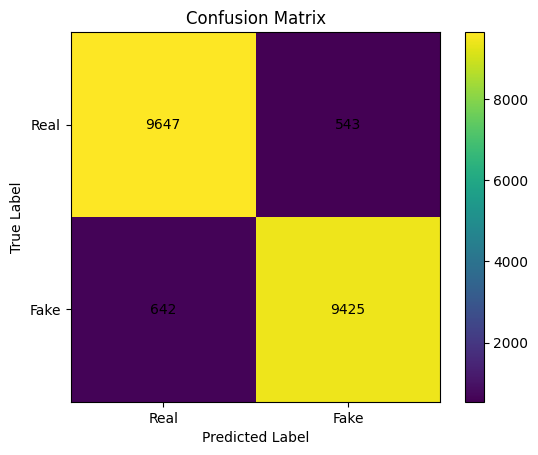

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

class_names = ["Real", "Fake"]

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)

plt.show()

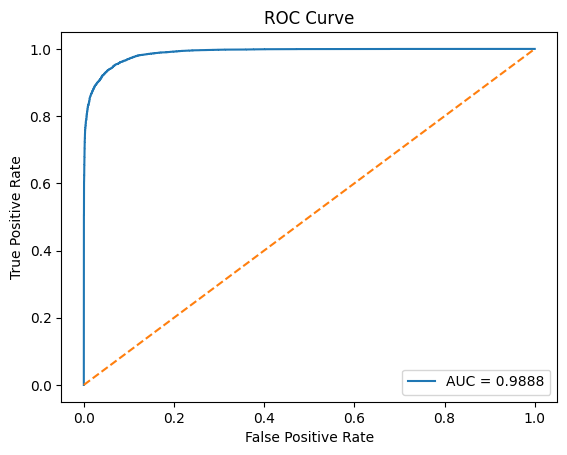

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()